In [1]:
import json
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pandas as pd

import importlib

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu 
from dredFISH.Utils.miscu import order_by_hc
from dredFISH.Utils import designu

from dredFISH.Design.model_v2p5_libsize_norm import CellTypeNet
from dredFISH.Design import data_loader_scrna 
importlib.reload(designu)

<module 'dredFISH.Utils.designu' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Utils/designu.py'>

In [2]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
torch.manual_seed(0)

# data

In [3]:
s0 = 1e4
libsize_norm = False
drprt = 0
studybatch = f'types_v26_Sep13_drprt{drprt:.1e}_libsize{libsize_norm}_scale{s0:.1e}'
studybatch

'types_v26_Sep13_drprt0.0e+00_libsizeFalse_scale1.0e+04'

In [4]:
rootdat_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/' 
glob.glob(f'{studybatch}*', root_dir=rootdat_dir)

['types_v26_Sep13_drprt0.0e+00_libsizeFalse_scale1.0e+04_lmd01.00e+00_lmd21.00e+00_nbit24_nrcn0_lr0.01']

In [5]:
%%time
trn_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_trn', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=64,
)
tst_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_tst', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=5000,
)
gsubidx = torch.load(
    os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna', 'gidx_sub140_smrt_v1.pt')
)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna', 'gidx_cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts_idx = torch.load(f)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna',      'cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts = torch.load(f)

n_gns = len(cnstrnts) # trn_dataloader.dataset.X.shape[1] # number of genes
n_cat = len(trn_dataloader.dataset.Ycat) # number of clusters


# load 1 batch
ftrs_batch, clsts_batch = next(iter(tst_dataloader))

CPU times: user 1min 22s, sys: 9.63 s, total: 1min 32s
Wall time: 11.1 s


In [6]:
nbits = [24] #[12, 18, 24]# [12, 18, 24] #[3,6,12,24] #,48,72,96]

mean_acc_all = []
n_acc_all = []

n_bits_acc = []

encx_all = []
prjx_all = []
embx_all = []
clsts_all = []

nrcn = 0
lr = 0.01
for nbit in nbits:
    print(nbit)
    
    dat_dir = rootdat_dir + f'{studybatch}_lmd01.00e+00_lmd21.00e+00_nbit{nbit}_nrcn{nrcn}_lr{lr}'
    print(os.path.isdir(dat_dir), dat_dir)

    # prep the model
    f = glob.glob(os.path.join(dat_dir, 'model*'))[0]

    reduction, cnst, mxpr, min_pos, n_bit, drprt, lmd1, lmd2, lmd3 = (os.path.basename(f)
                                                                            [len('model='):-len('.pt')]
                                                                            .replace('E-', 'expn').split('-')
                                                                     )
    lmd0 = 1
    mxpr = np.float64(mxpr)
    n_bit = int(n_bit)
    drprt = np.float64(drprt)
    # reduction, cnst, mxpr, min_pos, n_bit, drprt, lmd1, lmd2, lmd3
    n_rcn_layers = nrcn
    
    model= CellTypeNet(n_gns=     n_gns,                      
                       n_cat=     n_cat,                      
                       gsubidx= gsubidx,
                       cnstrnts_idx= cnstrnts_idx,
                       cnstrnts= cnstrnts,
                       n_rcn_layers=n_rcn_layers,
                       n_bit=     n_bit,
                       lmd0=      lmd0,
                       lmd2=      lmd2,
                       lmd3=1,
                       drprt=     drprt,
                       mxpr=      mxpr,
                       scale=     s0,
                       noise=     None
                      )
    model.load_state_dict(torch.load(f, map_location=device))

    # evaluate
    model.eval()
    with torch.no_grad():
        # validation dataset
        ftrs, clsts, ftrs_gsub = model.proc_batch(ftrs_batch, clsts_batch, device, libsize_norm=libsize_norm)

        # categorical
        plgt_fine, ftrs_rcn, emb = model.forward(ftrs, rnd=True)
        prds_fine = plgt_fine.max(1)[1]
        fine_acc_eval = (prds_fine == clsts).float().mean()
        
        # break down
        tmp = pd.DataFrame()
        tmp[0] = (prds_fine == clsts).numpy()
        tmp[1] = clsts.numpy()
        mean_acc = tmp.groupby(1).mean().values.reshape(-1,)
        n_acc = tmp.groupby(1).size().values.reshape(-1,)

        # enc mat
        encx = model.get_encmat(rnd=True).detach()
        # get embedding 
        prjx = model.get_prj(ftrs, rnd=False)
        # get normed
        embx = model.get_emb(ftrs, rnd=False)
        
        print(f"acc: {fine_acc_eval}")
        
        encx_all.append(encx)
        prjx_all.append(prjx)
        embx_all.append(embx)
        clsts_all.append(clsts)
        n_bits_acc.append(fine_acc_eval)
        
        mean_acc_all.append(mean_acc)
        n_acc_all.append(n_acc)
        
        # break

24
True /bigstore/GeneralStorage/fangming/projects/dredfish/res_nn/types_v26_Sep13_drprt0.0e+00_libsizeFalse_scale1.0e+04_lmd01.00e+00_lmd21.00e+00_nbit24_nrcn0_lr0.01
acc: 0.9721999764442444


In [7]:
scaleback = np.power(10, model.nrm.logscale).log10() #.exp()
scaleback.item()

4.0

In [17]:
ftrs_batch, clsts_batch

(tensor([[  0.,   0.,  97.,  ...,   0.,   0.,   0.],
         [  0.,   0.,  46.,  ...,   0.,   0.,   0.],
         [  0.,   0., 202.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0., 121.,  ...,   0.,   0.,   0.],
         [  0.,   0.,  49.,  ...,   0.,   0.,   0.],
         [  0.,   0., 283.,  ...,   0.,   0.,   0.]], dtype=torch.float64),
 tensor([ 7., 28., 41.,  ...,  6., 37., 22.], dtype=torch.float64))

In [20]:
ftrs.shape, ftrs

(torch.Size([5000, 23282]),
 tensor([[  0.,  21.,   0.,  ...,   0., 189.,   0.],
         [  0., 195.,   0.,  ..., 124.,  64.,   0.],
         [  0.,  31.,   0.,  ...,   0.,   0.,   0.],
         ...,
         [  0., 106.,   0.,  ...,   7.,  29.,   0.],
         [  0.,  38.,   0.,  ...,  26.,   0.,   0.],
         [  0.,  57.,   0.,  ...,   1., 113.,   0.]]))

In [24]:
# basicu.libsize_norm(ftrs_batch, scale=1e6)[:, cnstrnts_idx]
ftrs_batch[:,cnstrnts_idx]

tensor([[  0.,  21.,   0.,  ...,   0., 189.,   0.],
        [  0., 195.,   0.,  ..., 124.,  64.,   0.],
        [  0.,  31.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  0., 106.,   0.,  ...,   7.,  29.,   0.],
        [  0.,  38.,   0.,  ...,  26.,   0.,   0.],
        [  0.,  57.,   0.,  ...,   1., 113.,   0.]], dtype=torch.float64)

### check overall performance

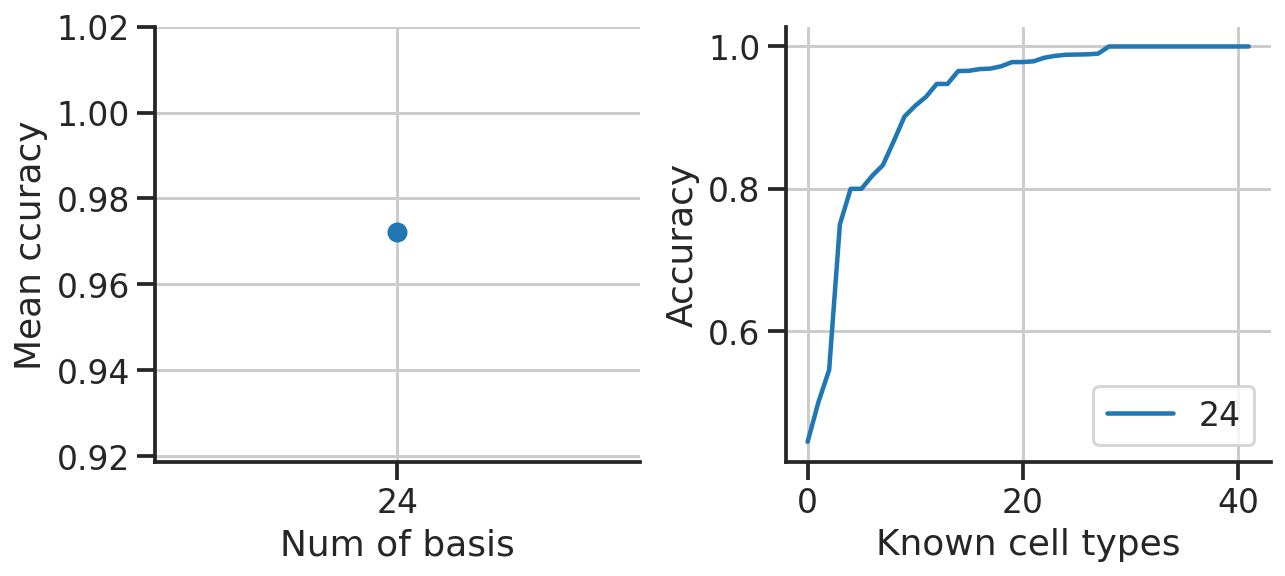

In [8]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax = axs[0]
ax.plot(nbits, n_bits_acc, '-o')
ax.set_ylim(ymax=1.02) #[0,1.02])
ax.set_xticks(nbits)
ax.set_xlabel('Num of basis')
ax.set_ylabel('Mean ccuracy')
sns.despine(ax=ax)

ax = axs[1]
for nbit, mean_acc in zip(nbits, mean_acc_all):
    ax.plot(np.sort(mean_acc), label=nbit)
ax.set_xlabel('Known cell types')
ax.set_ylabel('Accuracy')
ax.legend()
sns.despine(ax=ax)
fig.subplots_adjust(wspace=0.3)
plt.show()

### check structures
- encoding
- projection
- embedding

In [9]:
encx = encx_all[0].numpy()
prjx = prjx_all[0].numpy()
embx = embx_all[0].numpy()
clsts = clsts_all[0].numpy()
encx.shape, prjx.shape, clsts.shape

((23282, 24), (5000, 24), (5000,))

In [10]:
pmat = pd.DataFrame(encx) #, index=genes)
nzero_prbe_cond = pmat.sum(axis=1) > 0
pospmat = pmat[nzero_prbe_cond]
fpmat = pospmat.divide(pospmat.sum(axis=0), axis=1)

prjx_clsts, _ = basicu.group_mean(prjx, clsts)
# prjx_clsts_z  = basicu.zscore(prjx_clsts, allow_nan=True, axis=0)
# prjx_clsts_corr = np.corrcoef(prjx_clsts_z)

embx_clsts, _ = basicu.group_mean(embx, clsts)
embx_clsts_z  = basicu.zscore(embx_clsts, allow_nan=True, axis=0)
embx_clsts_corr = np.corrcoef(embx_clsts_z)

# order by HC
_rows = order_by_hc(embx_clsts)
_cols = order_by_hc(embx_clsts.T)

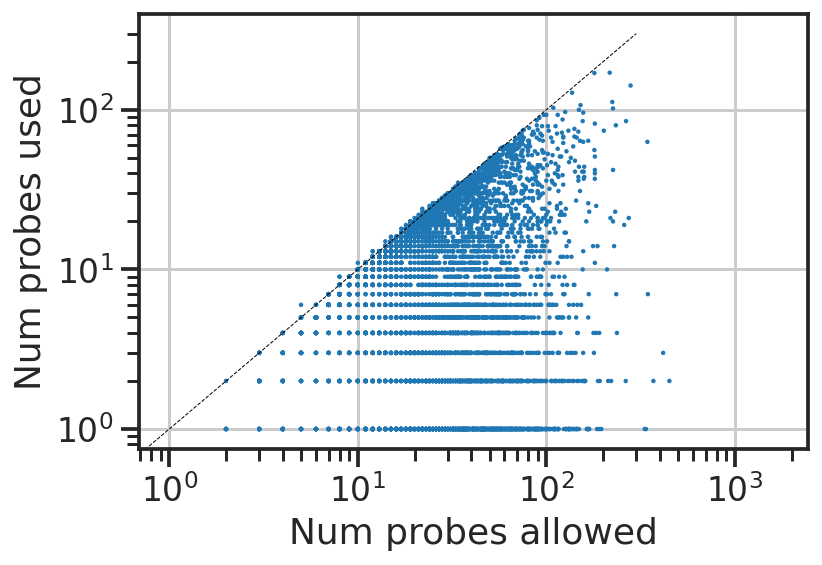

In [11]:
fig, ax = plt.subplots()
ax.scatter(cnstrnts, pmat.sum(axis=1), s=5, edgecolor='none')
ax.plot([0,300], [0,300], '--k', linewidth=0.5)
ax.set_xlabel('Num probes allowed')
ax.set_ylabel('Num probes used')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

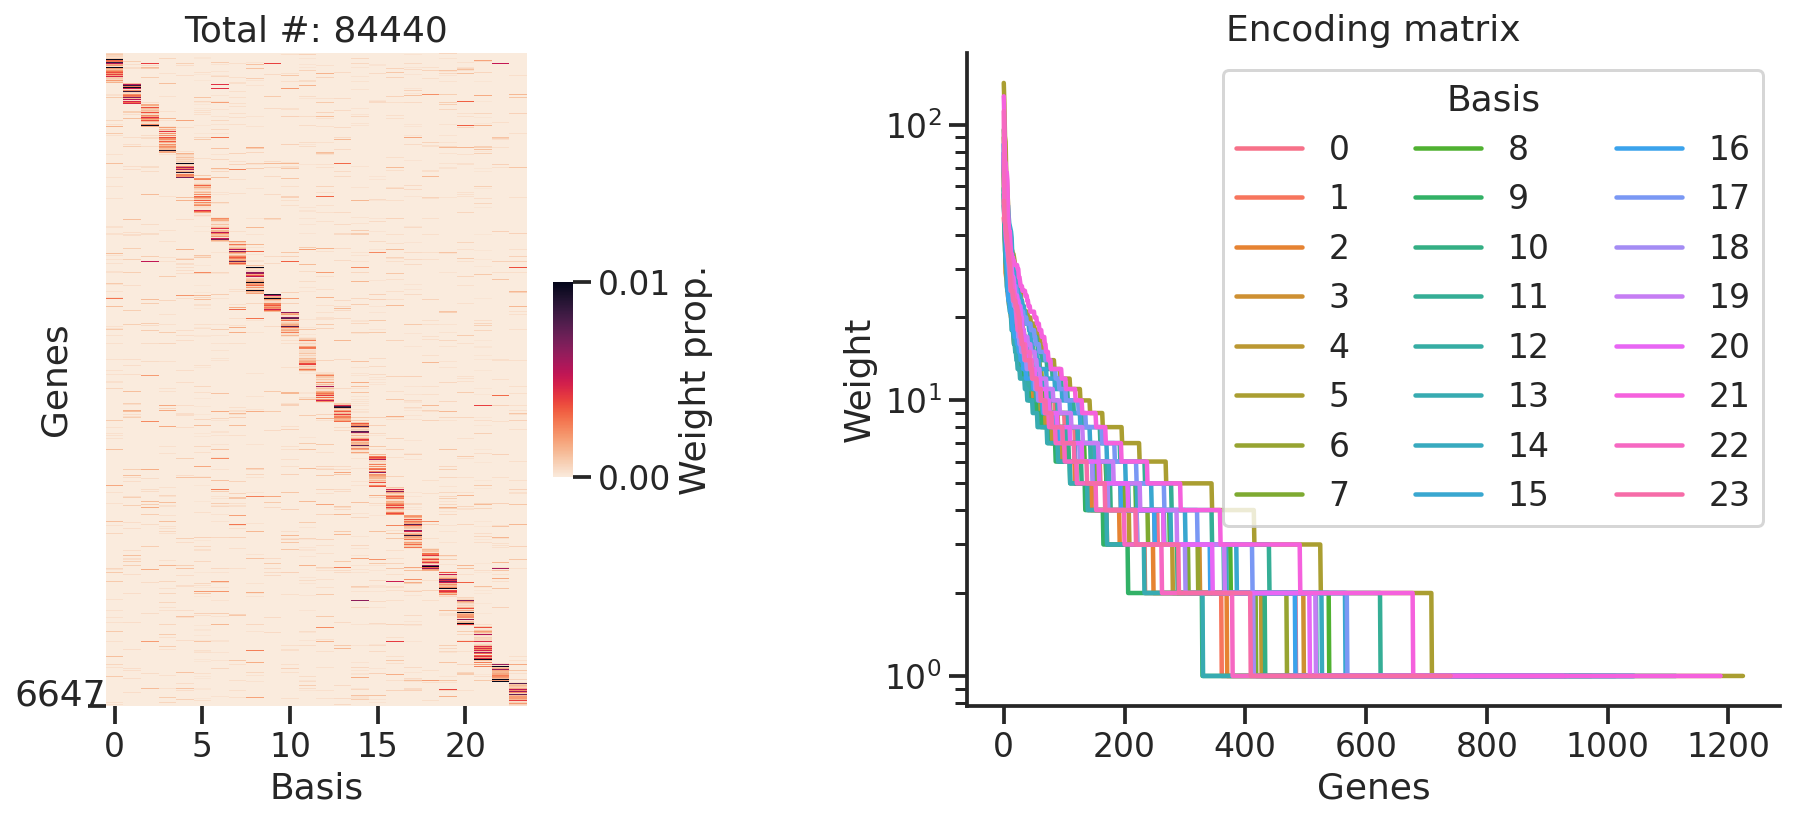

In [12]:
designu.plot_enc(pmat, fpmat)

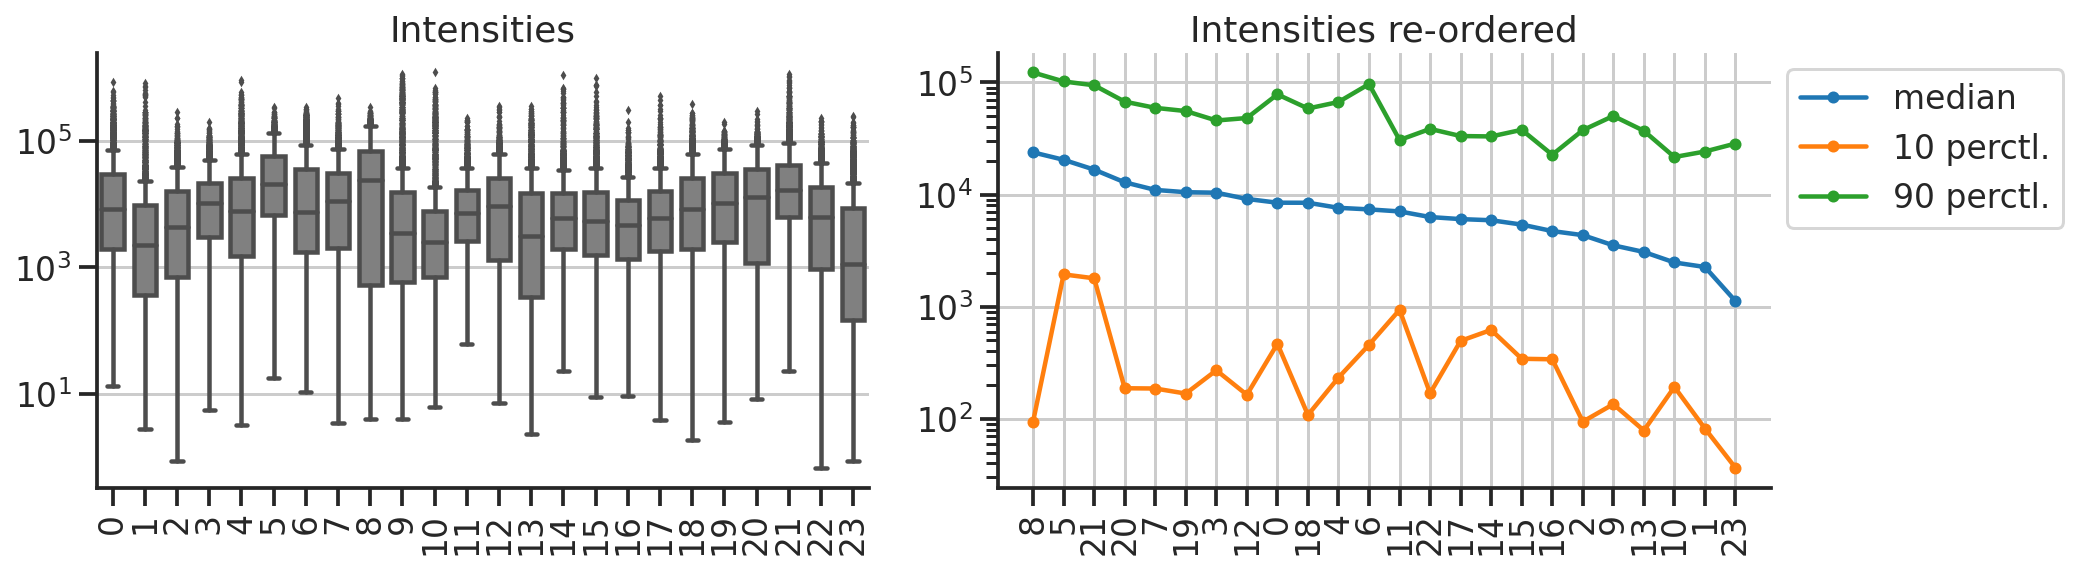

In [13]:
designu.plot_intn(prjx)

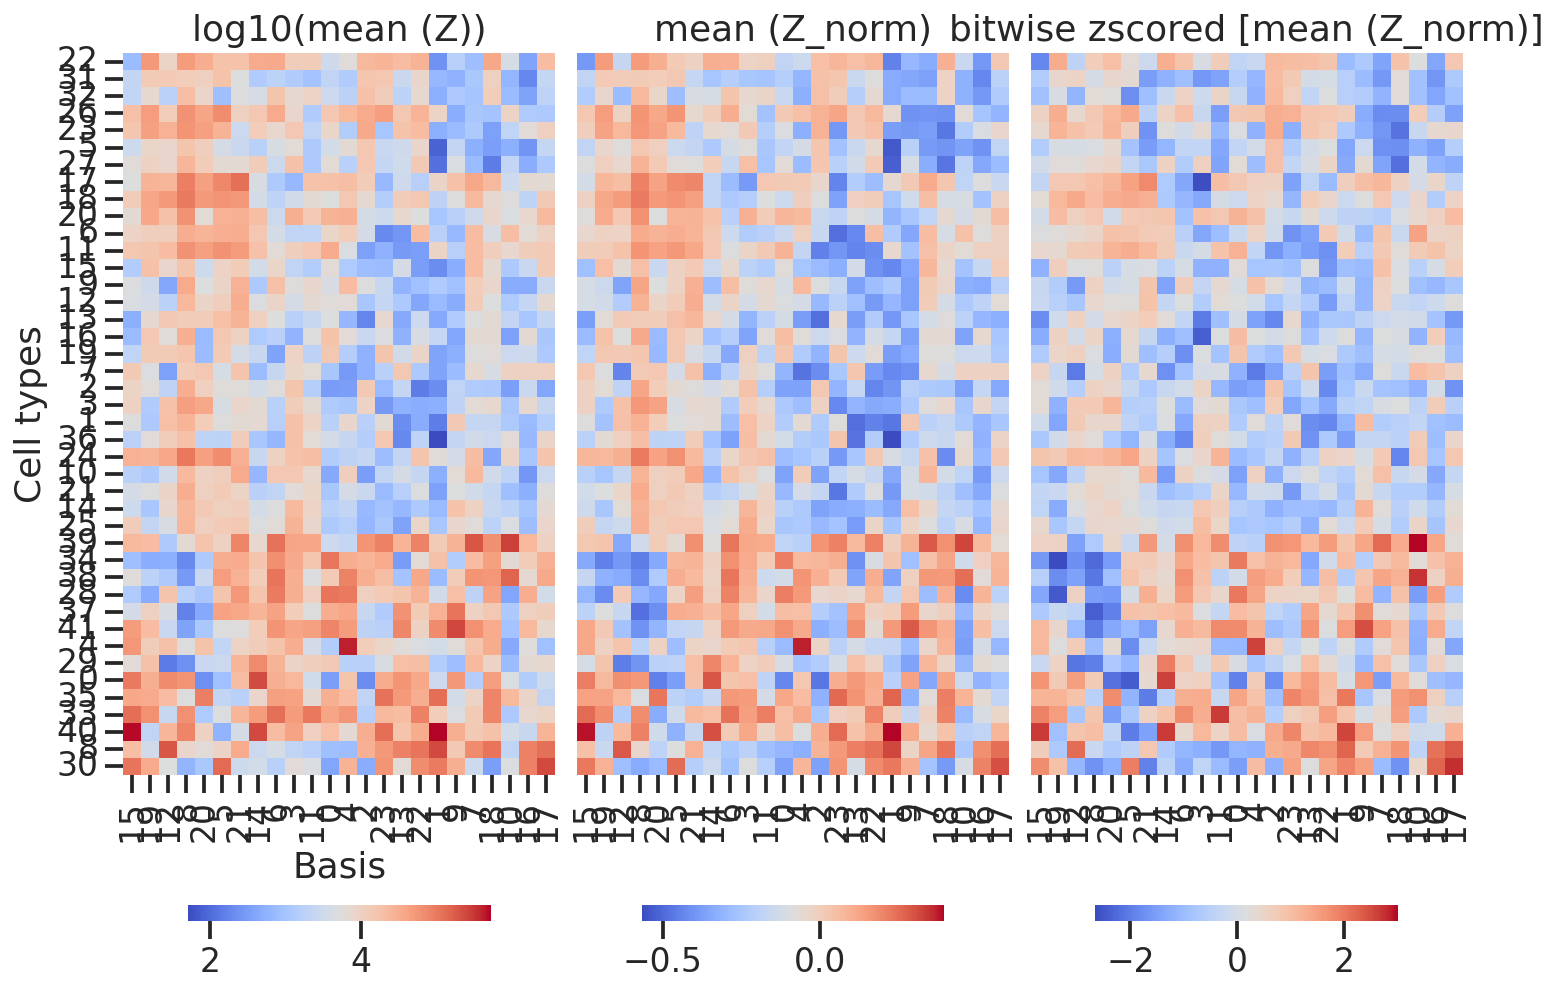

In [14]:
designu.plot_embx_clsts(prjx_clsts, embx_clsts, embx_clsts_z, 
                        _rows=_rows, _cols=_cols)

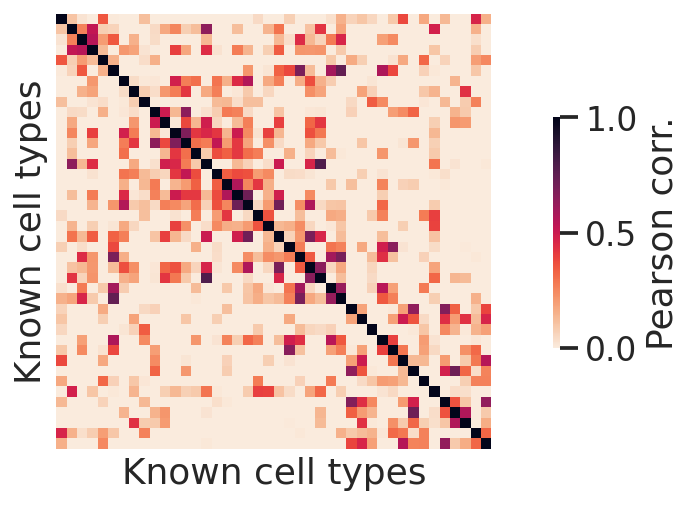

In [15]:
designu.plot_heatcorr(embx_clsts_corr, vmin=0)